In [2]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls
%cd drive
%cd 'My Drive'
%cd amalearn
!pwd
!pip3 install -e .

drive  sample_data
/content/drive
/content/drive/My Drive
/content/drive/My Drive/amalearn
/content/drive/My Drive/amalearn
Obtaining file:///content/drive/My%20Drive/amalearn
  Running setup.py develop for amalearn


In [4]:
color_dist = {'blue' : [4,1.2], 'green' : [1,6], 'orange' :[5,6.5]}
lyr_1 = [1,2,3]
lyr_2 = [4,5,6,7,8]
lyr_3 = [9,10,11]
links=[]
for lyr1 in range(3):
    for lyr2 in range(5):
        for lyr3 in range(3):
            temp = str(lyr_1[lyr1]) +str(' ')+str(lyr_2[lyr2]) +str(' ')+ str(lyr_3[lyr3])
            links.append(temp)
G_link = ['0 2','1 5','1 6','3 7','3 8','1 4','4 9','5 11','7 11','7 10', '6 10', '8 9']
B_link = ['0 1', '2 4', '2 6', '2 8','3 4', '3 5', '3 6','4 10','6 9','9 12','11 12']
p = [0.1,0.06,0.15,0.5,0.1,0.15,0.65,0.12,0.2,0.05,0.45]
def color_in(desired_link):
    T='orange'
    B_links = [B_link[i].split() for i in range(len(B_link))]
    G_links = [G_link[i].split() for i in range(len(G_link))]
    for i in range(len(B_links)):
        if B_links[i] == desired_link:
            T='blue'
    for i in range(len(G_links)):
        if G_links[i] == desired_link:
            T='green'
    return T


In [5]:
def return_reward(color):
    return np.random.normal(loc=color_dist[color][0], scale=color_dist[color][1])

In [6]:
def cal_reward(link_num):
    temp_str = links[link_num].split()
    total_reward = return_reward(color_in([ '0', temp_str[0] ]))
    total_reward += 30*np.random.binomial(1,p[int(temp_str[0])-1])
    total_reward += return_reward(color_in([ temp_str[0], temp_str[1] ]))
    total_reward += 30*np.random.binomial(1,p[int(temp_str[1])-1])
    total_reward += return_reward(color_in([ temp_str[1], temp_str[2] ]))
    total_reward += 30*np.random.binomial(1,p[int(temp_str[2])-1])
    total_reward += return_reward(color_in([ temp_str[2], '12' ]))
    return 100-total_reward

In [7]:
import gym
from amalearn.environment import EnvironmentBase
import math

class CNEnvironment(EnvironmentBase):
    def __init__(self, rewards, episode_max_length, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        super(CNEnvironment, self).__init__(action_space, state_space, id, container)
        self.arms_rewards = rewards
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }

    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward(action)

    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return

In [8]:
from amalearn.reward import RewardBase
import numpy as np

class NetworkReward(RewardBase):
    def __init__(self, action_num):
        super(NetworkReward, self).__init__()
        self.action_num = action_num

    def get_reward(self,action_num):
        return cal_reward(action_num)


In [9]:
def cal_policy(H, action_num):
        H_len = H.shape [0]
        denuminator = 0
        for i in range(H_len):
            denuminator += np.exp(H[i])
        return np.exp(H[action_num])/denuminator
    


In [10]:
import numpy as np
from amalearn.agent import AgentBase


class GradientBanditAgent(AgentBase):
    def __init__(self, id, environment):
        super(GradientBanditAgent, self).__init__(id, environment)
        self.reward_bar = 0
        self.itter_num = 0
        self.H_in = np.zeros(45)
        self.p = np.zeros(45)
        self.learning_rate = 1
        
    def set_learning_rate(self, alpha):
        self.learning_rate = alpha
        
    def update_R_bar(self, reward):
        self.reward_bar =  (reward + self.reward_bar*self.itter_num)/(self.itter_num + 1)
    
    def update_preferance(self, action_num, reward):
        H_out = np.zeros(self.H_in.shape [0])
        for i in range(self.H_in.shape [0]):
            if i != action_num:
                H_out[i] = self.H_in[i] - self.learning_rate*(reward - self.reward_bar)*cal_policy(self.H_in, action_num)
            else:
                H_out[i] = self.H_in[i] + self.learning_rate*(reward - self.reward_bar)*(1-cal_policy(self.H_in, action_num))
        return H_out
    
    def update_p(self):
        H_len = self.H_in.shape [0]
        denuminator = 0
        for i in range(H_len):
            denuminator += np.exp(self.H_in[i])
        for i in range(H_len):
            self.p[i] = np.exp(self.H_in[i])/denuminator
    
    def reset_attr(self):
        self.reward_bar = 0
        self.itter_num = 0
        self.H_in = np.zeros(45)
        self.p = np.zeros(45)
        self.learning_rate = 1
    
    def gradient_choose(self):
        return np.random.choice(45,1,p=self.p)
    
    def take_action(self) -> (object, float, bool, object):
        available_actions = self.environment.available_actions()
        self.update_p()
        best_action = self.gradient_choose()
        obs, r, d, i = self.environment.step(best_action[0])
        self.H_in = self.update_preferance(best_action[0], r)
        self.update_R_bar(r)
        self.itter_num +=1
        self.learning_rate = self.learning_rate*((self.itter_num)/(self.itter_num+1))
        #print(obs, r, d, i)
        #self.environment.render()
        if d == True:
            self.environment.reset()
            self.reset_attr()
        return r, best_action, self.learning_rate


In [11]:

     
class E_GreedyBanditAgent(AgentBase):
    def __init__(self, id, environment,arms):
        super(E_GreedyBanditAgent, self).__init__(id, environment)
        self.arms = 45
        self.itter_num = np.zeros(self.arms)
        self.r_bar = np.zeros(self.arms)
        self.p = (1/self.arms)*np.ones(self.arms)
        self.start = 0
        self.epsilon = 0.2
        self.cardinality=0
        
    def set_arms(self, arms):
        self.arms = arms
        
    def set_epsilon(self, epsilon):
        self.epsilon=epsilon
        
    def update_p(self,action_num):
        e = self.epsilon
        cardinality = self.cardinality
        p_a_star = 1 - e + e/(self.arms)
        p_a = e/self.arms
        q = np.zeros(self.arms)
        for i in range(self.arms):
            if i==action_num:
                q[i] = p_a_star
            else:
                q[i] = p_a
        return q
    
    def update_q_t(self,r_bar, t, r):
        self.cardinality += 1
        return (r_bar*t + r)/(t+1), t+1
    
    def reset_attr(self):
        self.arms = 45
        self.itter_num = np.zeros(self.arms)
        self.r_bar = np.zeros(self.arms)
        self.p = (1/self.arms)*np.ones(self.arms)
        self.start = 0
        self.epsilon = 0.2
        self.cardinality=0
    
    def EGreedy_choose(self):
        return np.random.choice(self.arms,1,p=self.p)
    
    def best(self):
        return np.argmax(self.r_bar)
        
    def take_action(self,epsilon) -> (object, float, bool, object):
        self.epsilon =epsilon
        available_actions = self.environment.available_actions()
        best_action = self.EGreedy_choose()
        obs, r, d, i = self.environment.step(best_action[0])
        self.r_bar[best_action[0]], self.itter_num[best_action[0]]=self.update_q_t(self.r_bar[best_action[0]], self.itter_num[best_action[0]], r)
        b = self.best()
        self.p = self.update_p(b)
        #self.epsilon = self.epsilon*((0.97)**self.cardinality)
        if d == True:
            self.environment.reset()
            self.reset_attr()
        return r, best_action

In [12]:
def average_percentage(W_S, all_actions):
    best_action = all_actions [-2]
    percetage_of_best_action = np.zeros(all_actions.shape [0] - W_S+1)
    for window_num in range(all_actions.shape [0] - W_S+1):
        temp = np.count_nonzero(all_actions[window_num : window_num + W_S] == best_action)
        percetage_of_best_action[window_num] = temp/W_S
    return percetage_of_best_action
def average_regret( all_rewards):
    #all_actions = normalize(all_actions)
    best_reward = np.sum(all_rewards[-10 : -1] )/(9)
    regret = np.zeros(all_rewards.shape [0])
    regret = best_reward - all_rewards
    regret = np.cumsum(regret)
    return regret


In [14]:
import numpy as np
import matplotlib.pyplot as plt
step = 1000
rewards = [NetworkReward(i) for i in range(45)]
env = CNEnvironment(rewards, 1000, '1')
agent = GradientBanditAgent('1', env)
run_size = 2000
q = np.zeros((run_size, 1000))
r = np.zeros((run_size, 1000))
l= np.zeros((run_size, 1000))
for run in range(run_size):
    for step in range(1000):
        r[run, step] ,q[run, step],l[run, step] = agent.take_action()
window_size = 50
best_action_percentage = np.zeros((run_size, 1000-49))
avrg_reward = np.zeros((run_size, 1000))
for run in range(run_size):
    best_action_percentage[run, :] = average_percentage(window_size, q[run, :])
    avrg_reward[run,:] = (average_regret( q[run, :]))
average_percentage = np.mean( best_action_percentage, axis = 0)
avrg_regret= (np.mean( avrg_reward, axis = 0))


Text(0, 0.5, 'Probablity')

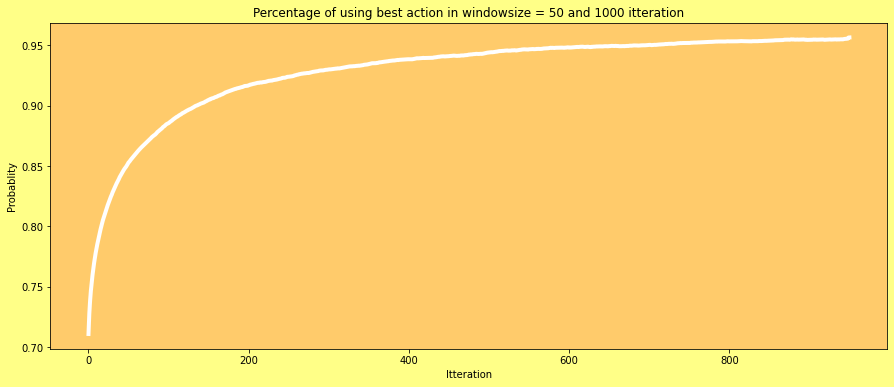

In [15]:
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
ax.plot(average_percentage, 'k-', lw=4, color='white')
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('Percentage of using best action in windowsize = 50 and 1000 itteration')
plt.xlabel('Itteration')

plt.ylabel('Probablity')

Text(0, 0.5, 'Award')

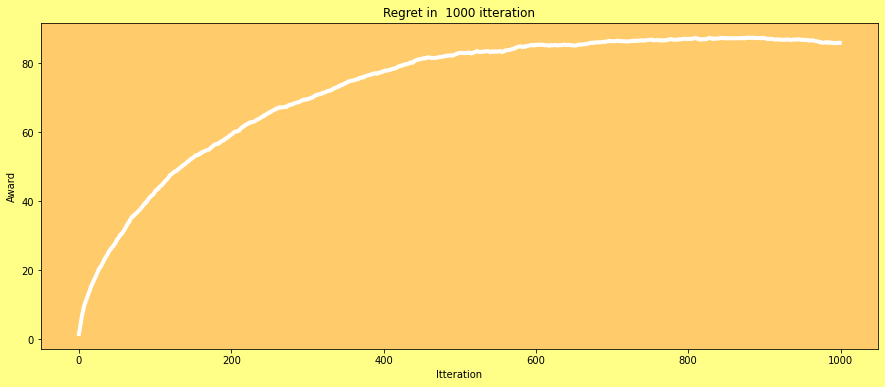

In [16]:
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
ax.plot(-avrg_regret , 'k-', lw=4, color='white')
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('Regret in  1000 itteration')
plt.xlabel('Itteration')
plt.ylabel('Award')


Text(0, 0.5, 'reward')

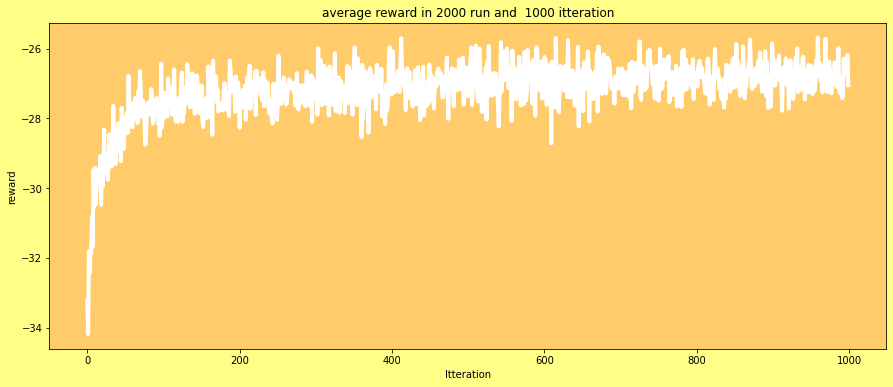

In [20]:
average_delay = np.mean(r, axis=0)
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
ax.plot(average_delay , 'k-', lw=4, color='white')
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('average reward in 2000 run and  1000 itteration')
plt.xlabel('Itteration')
plt.ylabel('reward')

Text(0, 0.5, 'action number')

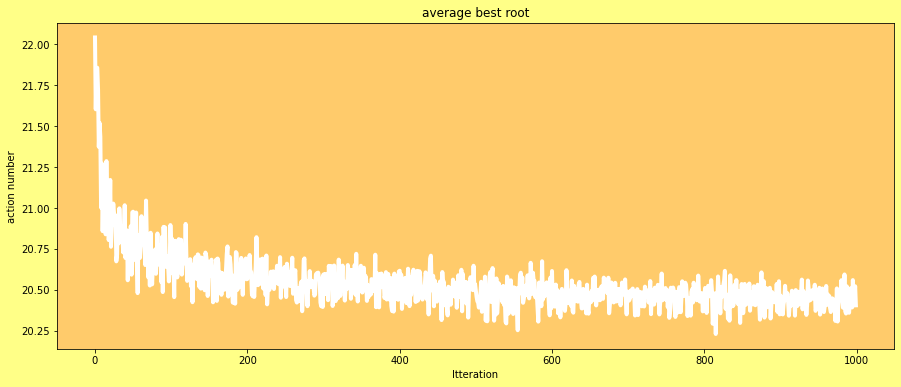

In [21]:
average_best_root = np.mean(q, axis=0)
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
ax.plot(average_best_root, 'k-', lw=4, color='white')
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('average best root')
plt.xlabel('Itteration')
plt.ylabel('action number')

In [13]:
import numpy as np
import matplotlib.pyplot as plt
step = 1000
rewards = [NetworkReward(i) for i in range(45)]
env = CNEnvironment(rewards, 1000, '1')
agent = E_GreedyBanditAgent('1', env,45)
agent.set_arms(45) 
run_size = 1000
q = np.zeros((run_size, 1000,5))
r = np.zeros((run_size, 1000,5))
eps = np.array([0.1, 0.2, 0.5, 0.7, .9])
for i in range(5):
  for run in range(run_size):
      for step in range(1000):
          r[run, step,i] ,q[run, step,i] = agent.take_action(eps[i])
window_size = 50
best_action_percentage = np.zeros((run_size, 1000-49,5))
avrg_reward = np.zeros((run_size, 1000,5))
for i in range(5):
  for run in range(run_size):
      best_action_percentage[run, :,i] = average_percentage(window_size, q[run, :,i])
      avrg_reward[run,:,i] = (average_regret( q[run, :,i]))
average_percentage = np.mean( best_action_percentage, axis = 0)
avrg_regret= (np.mean( avrg_reward, axis = 0))

Text(0, 0.5, 'Probablity')

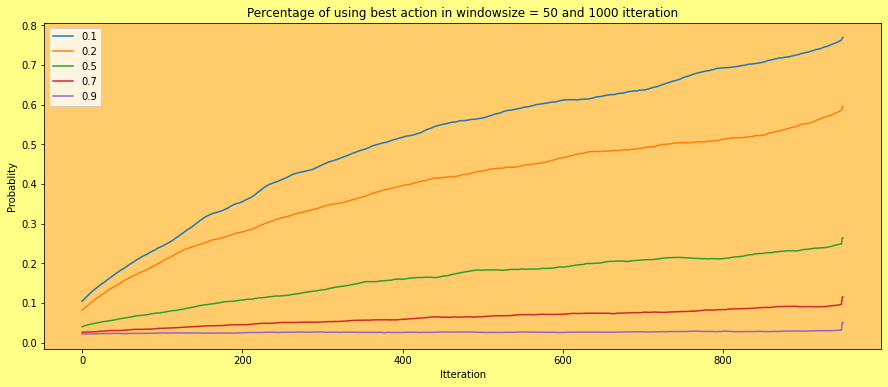

In [17]:
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
for i in range(5):
  ax.plot(average_percentage[:,i])
ax.legend([0.1, 0.2, 0.5, 0.7, .9])
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('Percentage of using best action in windowsize = 50 and 1000 itteration')
plt.xlabel('Itteration')
plt.ylabel('Probablity')


Text(0, 0.5, 'Probablity')

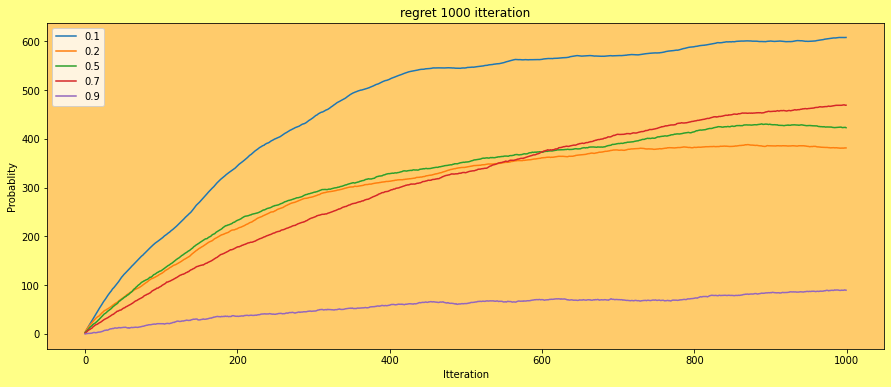

In [24]:
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
for i in range(5):
  ax.plot(-avrg_regret[:,i])
ax.legend([0.1, 0.2, 0.5, 0.7, .9])
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('regret 1000 itteration')
plt.xlabel('Itteration')
plt.ylabel('Probablity')

Text(0, 0.5, 'Probablity')

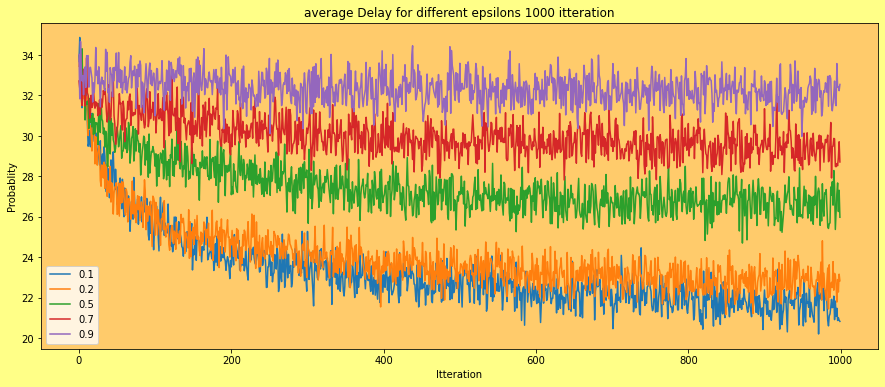

In [23]:
average_delay = np.mean(r, axis=0)
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
for i in range(5):
  ax.plot(100-average_delay [:,i])
ax.legend([0.1, 0.2, 0.5, 0.7, .9])
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('average Delay for different epsilons 1000 itteration')
plt.xlabel('Itteration')
plt.ylabel('Probablity')

Text(0, 0.5, 'Probablity')

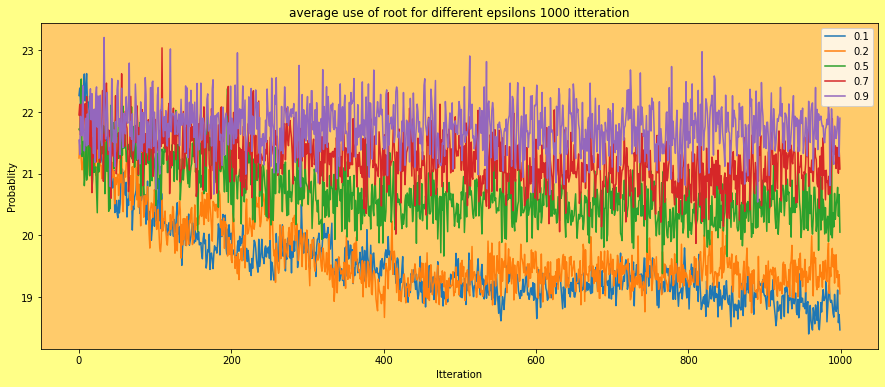

In [20]:

average_delay = np.mean(q, axis=0)
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
for i in range(5):
  ax.plot(average_delay [:,i])
ax.legend([0.1, 0.2, 0.5, 0.7, .9])
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('average use of root for different epsilons 1000 itteration')
plt.xlabel('Itteration')
plt.ylabel('Probablity')

In [22]:
links[19-3:19+3]

['2 4 10', '2 4 11', '2 5 9', '2 5 10', '2 5 11', '2 6 9']